# Argentina programa 4.0 - Módulo 3: Aprendizaje Automático
---

# Semana 6: Redes Neuronales Artificiales - Notebook 2

# Keras overview

## *Aprendizaje Profundo para Humanos*

"Keras es una API diseñada para seres humanos, no para máquinas. Keras sigue las mejores prácticas para reducir la carga cognitiva: ofrece APIs consistentes y simples, minimiza el número de acciones del usuario requeridas para los casos de uso comunes, y proporciona mensajes de error claros y procesables."

Keras es una API de alto nivel para diseñar, entrenar y evaluar redes neuronales. Originalmente se ejecutaba sobre muchos backends para la manipulación de tensores y la diferenciación automática, como Theano, CNTK, MxNet y Tensorflow. En las últimas versiones, sólo se soporta el backend de Tensorflow, y también viene unido a tensorflow como módulo `tf.keras`. Esta es la librería que utilizaremos durante el resto del curso.

Otro marco popular para la manipulación de tensores y la diferenciación automática es pyTorch (construido sobre Torch), con sus propias y populares APIs de alto nivel como fastai, PyTorch Lightning, etc.

Ambos son geniales.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Las estrellas
import tensorflow as tf
from tensorflow import keras

In [19]:
print(f'TensorFlow Version: {tf.__version__}')
print('Physical devices:')
tf.config.list_physical_devices()

TensorFlow Version: 2.13.0
Physical devices:


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preparación de los datos

Keras puede ser alimentado desde arrays numpy regulares, al igual que scikit-learn, pero también contiene una clase especializada `Dataset` que está optimizada para cargar datos en mini-lotes (lo que permite el entrenamiento fuera del núcleo de grandes conjuntos de datos), así como la creación de un pipeline de preprocesamiento y técnicas de aumento de datos.

Al igual que scikit-learn, proporciona una interfaz para conjuntos de datos populares. Echemos un vistazo a fashion-MINST, un conjunto de datos para la clasificación de ropa.

In [20]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

(60000, 28, 28) (60000,)
uint8


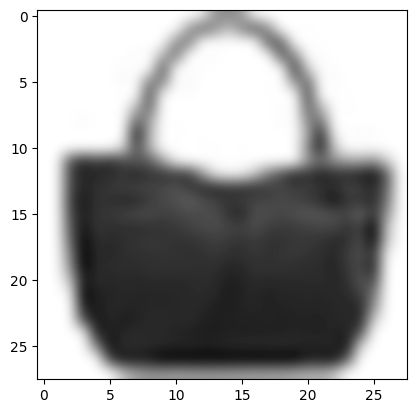

In [22]:
print(X_train_full.shape,y_train_full.shape)
print(X_train_full.dtype)
plt.imshow(X_train_full[100], cmap='binary', interpolation='bicubic')

Esta es una imagen de 28x28 píxeles de 8 bits, representados por enteros entre 0 y 255. Debemos normalizar estos datos. Una opción es utilizar un escalador min-max que en este caso consiste en normalizar por 255.

El entrenamiento de una red neuronal suele ser muy costoso, especialmente en conjuntos de datos grandes. Por esta razón, raramente se utiliza la validación cruzada. En su lugar se utiliza un conjunto de validación retenido (_held-out validation set_).

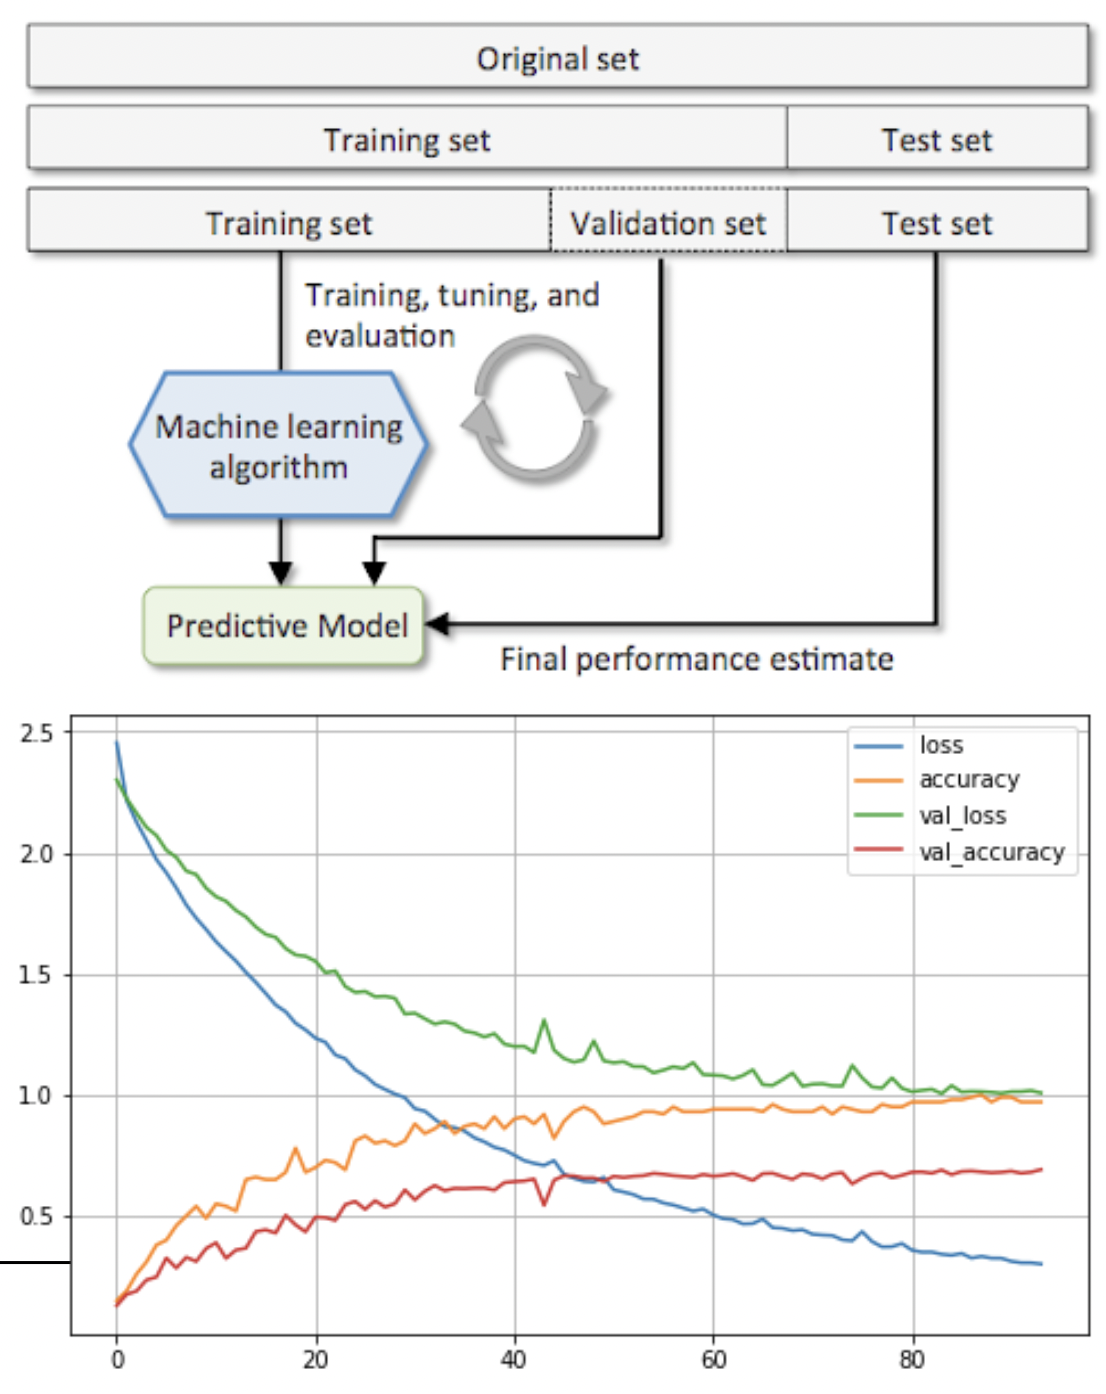

In [5]:
# Separación validación / entrenamiento + normalización de los pixeles
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

El *target* ha sido codificado y consiste de enteros de 0 a 9, cuyo [significado es](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data):

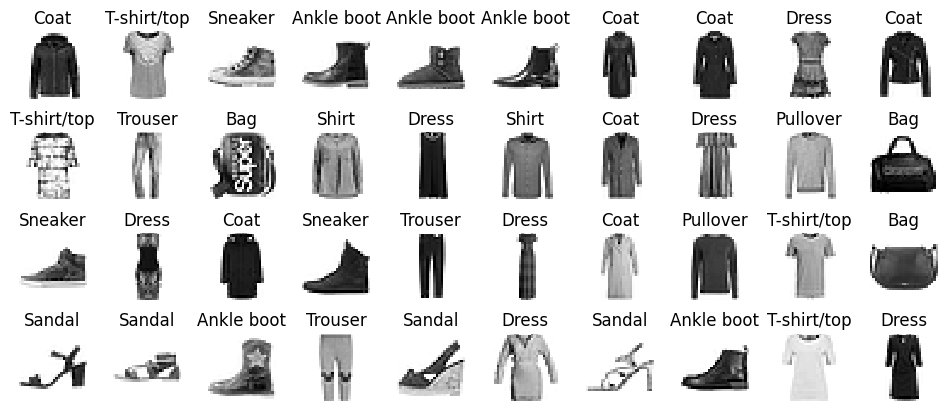

In [23]:
class_names = {
    0: 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Definición del modelo

Hay tres formas de definir un modelo con Keras:

* Secuencial: Podemos instanciar la clase `keras.models.Sequential` que toma una lista de capas y construye una red feed-forward. Esta es la clase más simple de las arquitecturas, donde dos capas se conectan sólo si son adyacentes.

* API funcional: Esta es la forma preferida. Nos permite definir cualquier red definida por un grafo acíclico de forma imperativa. Es muy flexible, y es el mismo paradigma en el que se basan pyTorch y Tensorflow 2.0.

* Subclasificación/*Sub-Classing*: Como en cualquier librería de python, podemos definir nuestras propias clases que heredan de las definidas en Keras. Esto añade la flexibilidad de diseñar comportamientos muy específicos para cada área y experimentar con nuevos paradigmas, a costa de perder muchas utilidades de alto nivel de Keras. Puede ser útil para la Investigación, pero no se recomienda en general.

## API Secuencial

In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Podemos crear un modelo _feed-forward_ instanciando un modelo secuencial y luego añadir las capas en orden:

In [8]:
#Crea un modelo secuencial
model = keras.models.Sequential()
#Añade capas
model.add(keras.layers.Flatten(input_shape=[28, 28])) #capa de entrada / input layer # matriz->vector (~ np.ravel)
model.add(keras.layers.Dense(300, activation="relu")) #capa oculta 1 / hidden 1 #784*300+300 = 785*300 = 235500
model.add(keras.layers.Dense(100, activation="relu")) #capa oculta 2 / hidden 2 #300*100+100=301*100=30100
model.add(keras.layers.Dense(10, activation="softmax")) #salida / output #100*10+10=10100

O podemos simplemente pasar una lista de capas

In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

Observe que en la primer capa, especificamos la forma de entrada (`input_shape`). Esta información es suficiente para especificar cuántos pesos tiene cada capa posterior. La primera capa no tiene parámetros, es sólo una transformación de datos (que aplana la matriz en un vector).

Las funciones de activación son muy importantes: componen toda la no linealidad del modelo. En las capas internas, las opciones más comunes son `tanh` (para redes poco profundas) y `ReLU` (para redes profundas). En la última capa, la función de activación depende del problema que queramos resolver:

* Las tareas de clasificación utilizan una sigmoide (para la clasificación binaria) o una softmax (para la clasificación multiclase).

* Las tareas de regresión sin restricciones no suelen utilizar ninguna función de activación: La última capa es simplemente un modelo lineal. Si queremos imponer ciertas restricciones, podemos utilizar un ReLU para salidas acotadas por un lado, o su versión suavizada `softplus`, y un `sigmoide` o un `tanh` para salidas acotadas por ambos lados.

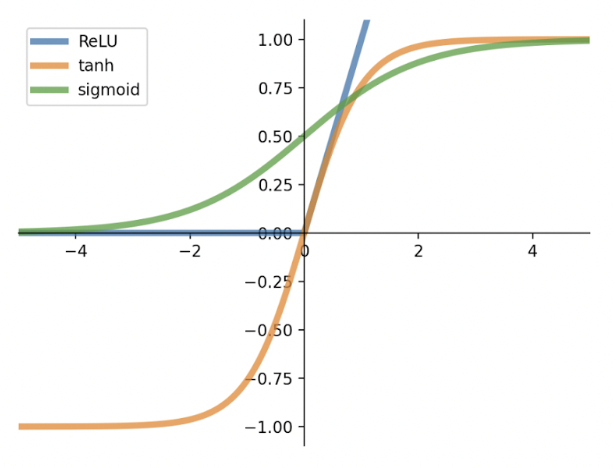

In [26]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'mish',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

## API funcional

Al utilizar la API funcional, definimos nuestro modelo de forma imperativa, aplicando cada capa como una función a las salidas de las capas anteriores. Keras trazará automáticamente todas estas conexiones y generará un modelo entre la(s) capa(s) de entrada y la(s) de salida. De esta manera, podemos definir modelos arbitrarios.

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
# Necesitamos definir una capa especial, que es el punto de entrada al modelo:
input_ = keras.layers.Input(shape=[28, 28])
# y luego instanciar cada capa, y aplicarla como una función a la salida de la capa anterior
flatten = keras.layers.Flatten()(input_)
hidden1 = keras.layers.Dense(300, activation="relu")(flatten)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(10, activation="softmax")(hidden2)
#Una vez que hemos llegado a las salidas, podemos definir el modelo:
model = keras.models.Model(inputs=[input_], outputs=[output])

# Compilación del modelo

Una vez que el modelo es instanciado y definido, necesitamos "Compilarlo" antes de poder utilizarlo. En el paso de compilación, Keras creará el gráfico computacional del modelo en TensorFlow. En este paso, definimos todas las demás piezas importantes de nuestro modelo:

* La **función de pérdida**, que la retropropagación tratará de minimizar (por ejemplo, MSE)
* El **optimizador** que utilizaremos para minimizar la pérdida (por ejemplo, SGD)
* Las **métricas** que querremos seguir a lo largo del entrenamiento

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

La función de pérdida define el problema que intentaremos resolver, y está íntimamente relacionada con la función de activación de la capa de salida. En las tareas de clasificación hay que tener en cuenta algunas sutilezas.

Para un problema de clasificación binaria, normalmente estaremos en una de estas dos situaciones:
* Usando una sola neurona en la capa de salida, modelaremos la probabilidad de asignación a una de las dos clases. La función de activación que debemos utilizar entonces es un `sigmoid`, de manera que la salida es un número real entre 0 y 1, y la función de pérdida correspondiente es la entropía_cruzada binaria (`binary_cross_entropy`). Esta última capa actúa como un regresor logístico sobre las salidas de las capas anteriores.

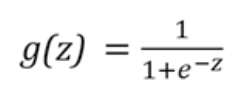

* Utilizando dos neuronas en la capa de salida, queremos modelar la probabilidad de asignación a cada una de las clases. Las salidas de estas dos neuronas deben estar entre 0 y 1 y sumar 1, por lo que la función de activación adecuada es la `softmax`. La función de pérdida correspondiente debe ser la misma, sólo que cuando el número de neuronas coincide con el número de clases se reescribe de forma adecuada para la clasificación multiclase: `categorical_cross_entropy`. Esta función, por defecto, está definida para ser usada con _targets_ que son codificados _one-hot_. En el caso de que usemos un codificador ordinal, podemos transformar nuestros objetivos usando `tensorflow.keras.utils.to_categorical`.

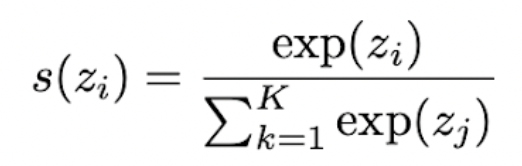

* Cuando la categoría tiene codificación ordinal (no _one hot_) una alternativa es usar la función de pérdida adaptada llamada `sparse_categorical_cross_entropy`. En ese caso también podemos utilizar una función de activación `softmax` para la clasificación multiclase. **Atención:** en este caso el target es un número de 0 a 9 (en este ejemplo) pero la salidad es en codificación tipo one-hot.


Podemos acceder a las diferentes capas a través del atributo `layers`.

In [29]:
model.layers

Y podemos imprimir un resumen de nuestro modelo, y graficarlo, usando las siguientes utilidades:

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


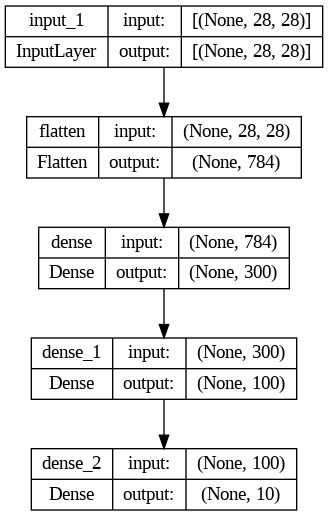

In [31]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

*Cada capa* tiene atributos a los que podemos acceder, como su nombre, así como métodos, que pueden darnos los pesos reales de los modelos.

In [32]:
hidden1 = model.layers[2]
print(hidden1.name)
weights, biases = hidden1.get_weights()
print(weights.shape)
#plt.hist(weights[0])
#print(weights[0], biases[0])

dense
(784, 300)


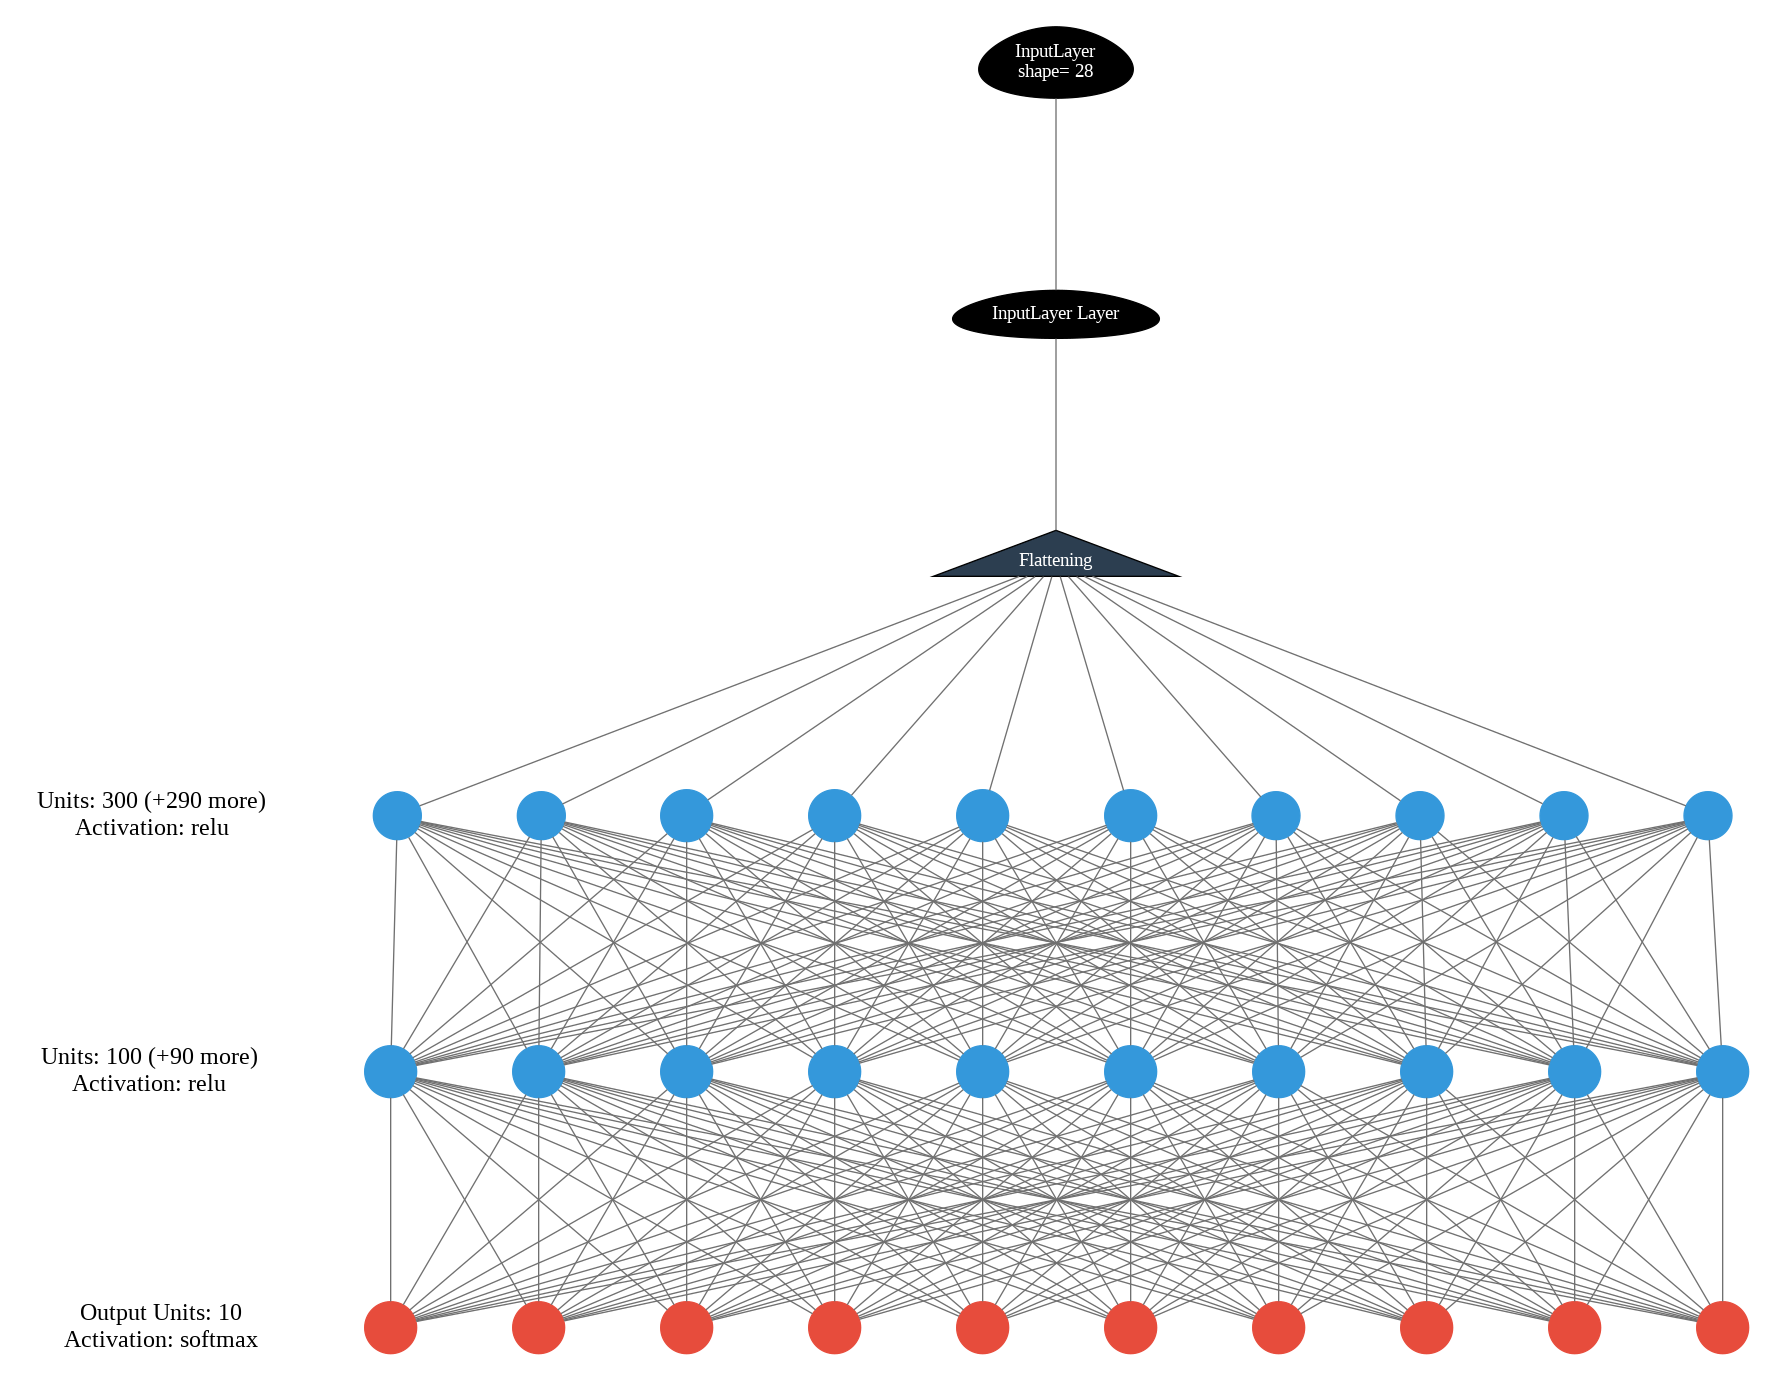

In [33]:
!pip install keras-visualizer
from keras_visualizer import visualizer
visualizer(model, file_format='png', view=True)
from IPython.display import Image, display
display(Image('graph.png'))

Una forma alternativa y pedagógica de visualizar la red:

# Entrenamiento

Entrenar un modelo en keras es tan sencillo como ejecutar el método `fit`. Entre los parámetros que podemos establecer, tenemos el número de épocas para las que entrenaremos, el batch_size, así como algunos datos de validación que podemos utilizar para seguir la evolución de las métricas de evaluación (definidas en el paso de compilación).

In [36]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 12s 4ms/step - loss: 0.7279 - accuracy: 0.7616 - val_loss: 0.5231 - val_accuracy: 0.8250
Epoch 2/20
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4938 - accuracy: 0.8271 - val_loss: 0.4386 - val_accuracy: 0.8538
Epoch 3/20
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4473 - accuracy: 0.8423 - val_loss: 0.5238 - val_accuracy: 0.8026
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4191 - accuracy: 0.8541 - val_loss: 0.3959 - val_accuracy: 0.8644
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3991 - accuracy: 0.8606 - val_loss: 0.3768 - val_accuracy: 0.8684
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3800 - accuracy: 0.8659 - val_loss: 0.3765 - val_accuracy: 0.8690
Epoch 7/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3668 - accuracy: 0.8707 - val_loss: 0.3644 - val_accura

El método `fit` devuelve un objeto History, que contiene toda la información de entrenamiento como diccionarios. Esto nos permite analizar el entrenamiento de nuestro modelo:

In [37]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 1719}

El atributo `history` nos da las métricas de entrenamiento, que podemos graficar:

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

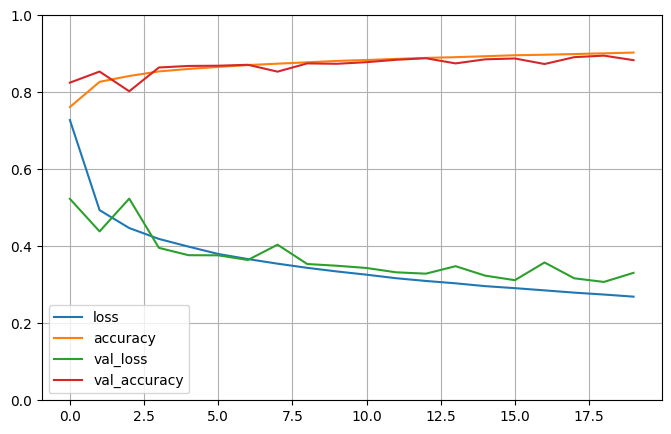

In [39]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Evaluación del modelo y predicción

Para evaluar el rendimiento de nuestro modelo en un conjunto de pruebas o de validación, podemos utilizar el método `evaluate`.

In [40]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 74.1897 - accuracy: 0.8329


[74.18972778320312, 0.8328999876976013]

Para calcular las predicciones sobre nuevos puntos de datos, utilizamos el método `predict`, que devuelve las probabilidades de cada clase (similar al método `predict_proba` de scikit-learn).

In [42]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 20ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Podemos usar esas probabilidades para atribuir las clases:

In [44]:
y_pred = np.argmax(y_proba, axis=1)
y_pred

array([9, 2, 1])

In [45]:
[class_names[i] for i in y_pred]

['Ankle boot', 'Pullover', 'Trouser']

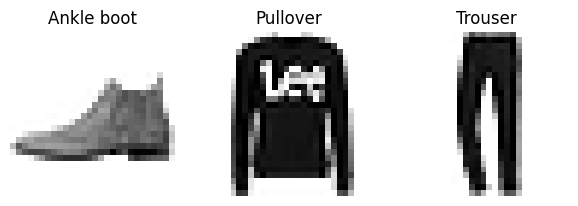

In [46]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Persistencia: Guardar y cargar modelos

Para guardar nuestros modelos ajustados necesitamos guardar tanto la estructura de la red como los pesos. Esto es más eficiente que guardar toda la clase. Keras proporciona métodos transparentes para guardar y cargar modelos utilizando un formato H5.

In [47]:
model.save("my_keras_model.h5")
# o se puede salvar en un formato específico de keras
model.save('my_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Se puede cargar más tarde (en otro día, u ordenador) como


In [48]:
model = keras.models.load_model("my_keras_model.h5")

alternativamente:

In [49]:
model_copy = keras.models.load_model('my_model.keras')

Una opción más liviana es sólo guardar los pesos de cada capa:

In [50]:
model.save_weights("my_keras_weights.ckpt")

Y antes de cargar los pesos, tendremos que definir la arquitectura del modelo, y tiene que ser idéntica a la que utilizamos para guardarla. Sólo entonces, podemos cargar diferentes pesos.

In [51]:
model.load_weights("my_keras_weights.ckpt")

Esta opción puede ser útil para guardar diferentes etapas del proceso de entrenamiento de nuestro modelo.

# Llamadas de retorno / _Callbacks_

Los _callbacks_ son funciones que podemos especificar para que se ejecuten durante el entrenamiento. Por ejemplo, podemos instruir a nuestro modelo para que se guarde al final de cada epoch, o implementar un `EarlyStopping` y detener el ajuste si la métrica de validación no mejora. Incluso podemos definir nuestros propios _callbacks_ para, por ejemplo, enviarnos periódicamente un correo electrónico con las métricas de entrenamiento.

Los _callbacks_ se pasan al método `fit`.

## Checkpoints

In [52]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                     callbacks=[checkpoint_cb])

Epoch 1/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2637 - accuracy: 0.9047 - val_loss: 0.3032 - val_accuracy: 0.8900
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2595 - accuracy: 0.9062 - val_loss: 0.2994 - val_accuracy: 0.8944
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2543 - accuracy: 0.9079 - val_loss: 0.3733 - val_accuracy: 0.8622
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2501 - accuracy: 0.9111 - val_loss: 0.3063 - val_accuracy: 0.8922
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2480 - accuracy: 0.9111 - val_loss: 0.2935 - val_accuracy: 0.8920
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2412 - accuracy: 0.9130 - val_loss: 0.3022 - val_accuracy: 0.8906
Epoch 7/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2377 - accuracy: 0.9161 - val_loss: 0.2972 - val_accuracy:

In [53]:
model = keras.models.load_model("my_keras_model.h5")

In [54]:
model.evaluate(X_train,y_train)

1719/1719 [==============================] - 6s 4ms/step - loss: 0.1835 - accuracy: 0.9354


[0.18353214859962463, 0.9354000091552734]

In [55]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 70.5046 - accuracy: 0.8441


[70.50457763671875, 0.8440999984741211]

## Detención Temprana / _Early Stopping_

Considerado a veces como un método de regularización, este procedimiento se encarga de detener la etapa de entrenamiento antes de que converja al mínimo. Monitoriza las métricas de validación y cuando el aumento de la puntuación deja de ser significativo durante un determinado número de iteraciones, detiene el entrenamiento.

Este método se implementa en keras como un _Callback_. Tenemos que establecer la métrica `monitor`, el `min_delta` y la `patience`. También proporciona una forma de almacenar los pesos del mejor modelo, para que cuando el entrenamiento se detenga, se restablezcan a ese valor.

Veamos la Detención Temprana en acción mediante el sobreajuste de un conjunto de datos:

In [56]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Tenemos que definir una capa especial, que es el punto de entrada al modelo:
input_ = keras.layers.Input(shape=[28, 28])
#y luego instanciar cada capa, y aplicarlo como una función a la salida de la capa anterior
flatten = keras.layers.Flatten()(input_)
hidden1 = keras.layers.Dense(300, activation="relu")(flatten)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(10, activation="softmax")(hidden2)

#Una vez alcanzada la salida, podemos definir el modelo:
model = keras.models.Model(inputs=[input_], outputs=[output])

# Compilación
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Epoch 1/50
4/4 [==============================] - 1s 257ms/step - loss: 2.3264 - accuracy: 0.0700 - val_loss: 2.2873 - val_accuracy: 0.1558
Epoch 2/50
4/4 [==============================] - 1s 220ms/step - loss: 2.2021 - accuracy: 0.2000 - val_loss: 2.1952 - val_accuracy: 0.2056
Epoch 3/50
4/4 [==============================] - 1s 219ms/step - loss: 2.1065 - accuracy: 0.3200 - val_loss: 2.1330 - val_accuracy: 0.2274
Epoch 4/50
4/4 [==============================] - 1s 220ms/step - loss: 2.0339 - accuracy: 0.3700 - val_loss: 2.0749 - val_accuracy: 0.2068
Epoch 5/50
4/4 [==============================] - 0s 119ms/step - loss: 1.9455 - accuracy: 0.3300 - val_loss: 2.0229 - val_accuracy: 0.2162
Epoch 6/50
4/4 [==============================] - 1s 219ms/step - loss: 1.8813 - accuracy: 0.3700 - val_loss: 1.9551 - val_accuracy: 0.3212
Epoch 7/50
4/4 [==============================] - 0s 113ms/step - loss: 1.8149 - accuracy: 0.4200 - val_loss: 1.9345 - val_accuracy: 0.2352
Epoch 8/50
4/4 [====

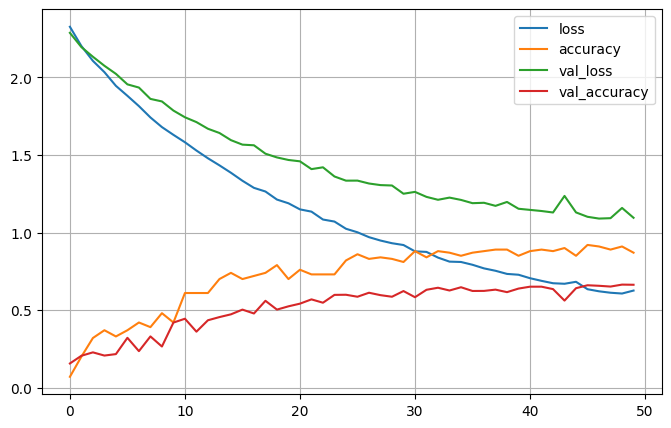

In [57]:
#pequeño conjunto de datos para sobreajustar rápidamente
history = model.fit(X_train[:100], y_train[:100], epochs=50,
                    validation_data=(X_valid, y_valid))

import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

Para detener el entrenamiento antes de que se produzca el sobreajuste, vamos a utilizar el _callback_ _EarlyStopping_

In [58]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Tenemos que definir una capa especial, que es el punto de entrada al modelo:
input_ = keras.layers.Input(shape=[28, 28])
#y luego instanciar cada capa, y aplicarlo como una función a la salida de la capa anterior
flatten = keras.layers.Flatten()(input_)
hidden1 = keras.layers.Dense(300, activation="relu")(flatten)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(10, activation="softmax")(hidden2)

#Una vez alcanzada la salida, podemos definir el modelo:
model = keras.models.Model(inputs=[input_], outputs=[output])

# Compilación
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Epoch 1/200
4/4 [==============================] - 1s 169ms/step - loss: 2.2232 - accuracy: 0.2400 - val_loss: 2.1769 - val_accuracy: 0.2478
Epoch 2/200
4/4 [==============================] - 0s 120ms/step - loss: 2.0972 - accuracy: 0.3400 - val_loss: 2.0916 - val_accuracy: 0.3086
Epoch 3/200
4/4 [==============================] - 0s 113ms/step - loss: 1.9987 - accuracy: 0.4600 - val_loss: 2.0390 - val_accuracy: 0.3210
Epoch 4/200
4/4 [==============================] - 1s 221ms/step - loss: 1.9331 - accuracy: 0.3800 - val_loss: 1.9773 - val_accuracy: 0.3732
Epoch 5/200
4/4 [==============================] - 0s 115ms/step - loss: 1.8478 - accuracy: 0.5000 - val_loss: 1.9341 - val_accuracy: 0.3778
Epoch 6/200
4/4 [==============================] - 0s 112ms/step - loss: 1.7849 - accuracy: 0.5500 - val_loss: 1.8730 - val_accuracy: 0.4002
Epoch 7/200
4/4 [==============================] - 0s 112ms/step - loss: 1.7214 - accuracy: 0.5300 - val_loss: 1.8323 - val_accuracy: 0.3402
Epoch 8/200
4

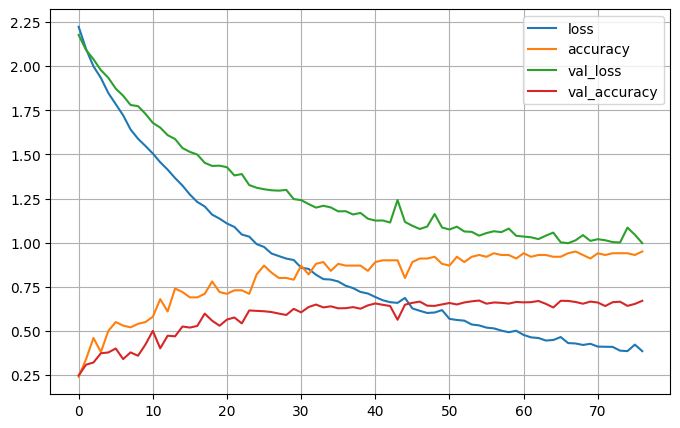

In [59]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train[:100], y_train[:100], epochs=200,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

## Otras técnicas de regularización

Sabemos que podemos flexibilizar nuestra red añadiendo más neuronas o capas. Pero, ¿cómo podemos regularizarla para evitar el sobreajuste? A continuación, hablaremos de algunas técnicas comunes.

### Reducción de pesos / _Weight Decay_

La idea por detrás de la reducción de pesos es la misma que la de los métodos de regularización Ridge y Lasso para modelos lineales: Cuanto más pequeños sean los pesos, menores serán los *grados de libertad efectivos* de nuestro modelo. Además, al evitar que los pesos sean grandes, obligamos a nuestra red a no ser demasiado dependiente de una característica determinada, y por tanto de su ruido.

Podemos especificar el método de regularización en la instatiación de la capa, utilizando el método `kernel_regularizer`. Podemos entonces utilizar un Ridge (`keras.regularizers.l2()`), Lasso (`keras.regularizers.l1()`) o una red elástica (`keras.regularizers.l1_l2()`).

In [60]:
#Por ejemplo, para definir una capa densa con una función de activación ReLU, 100 neuronas y una regularización l2 (~Ridge) con un factor alfa de 0,01:
layer = keras.layers.Dense(100,
                          activation='relu',
                          kernel_regularizer=keras.regularizers.l2(0.01))

Para ahorrar en la escritura, podemos definir nuestras capas regularizadas utilizando la herramienta `parcial`:

In [61]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                          activation='relu',
                          kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

### _Dropout Layer_

Una forma popular de regularizar las redes neuronales profundas se propuso en dos artículos de 2012 y 2014: En cada paso de entrenamiento, algunas de las neuronas tienen una probabilidad $p$ de "apagarse" (sus salidas se ponen a cero). Esto se hace sólo durante el entrenamiento, y para la predicción todas las neuronas están encendidas (y sus pesos debidamente reponderados para tener en cuenta el aumento de $1/p$ en la señal).

La idea principal detrás de esto es forzar a la red a no depender demasiado de una neurona en particular, forzándola a entregar *buenos* resultados incluso cuando esa neurona está apagada. Existen también algunas variantes de este modelo, como `Alpha-Dropout` y `MCDropout`.

En Keras, este tipo de regularización se ha implementado como una capa, por lo que sólo tenemos que importarla e instanciarla. La probabilidad de desactivación $p$ se establece a través del parámetro `rate`, y la Capa se encarga de retropropagar adecuadamente la señal así como de ajustar los pesos para la evaluación y predicción.

In [62]:
#Por ejemplo el modelo primero del notebook, pero con Dropout luego de cada Layer:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), #equivale a apagar algunos pixeles de la imagen
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

# Más a fondo

## El problema de los gradientes que se anulan o explotan

Debido a la propia naturaleza de la retropropagación, los gradientes son inestables a través de las capas, y la velocidad a la que aprende cada capa depende de la profundidad a la que se encuentre. La naturaleza multiplicativa de la retropropagación hace que cualquier aumento/disminución coordinada de los gradientes se exponga a medida que retrocedemos en la red:
* Si los gradientes disminuyen a medida que retrocedemos por la red, las capas más cercanas a la entrada cambiarán a un ritmo mucho menor que las capas más cercanas a la salida. Esto puede impedir que la red converja a una solución óptima. Esto se conoce como el problema de los *gradientes evanescentes*, y hace que el tiempo de aprendizaje aumente significativamente.
*Si los gradientes aumentan a medida que retrocedemos, el algoritmo empieza a divergir. Este es el problema de los *gradientes explosivos*, y impide que el sistema converja.

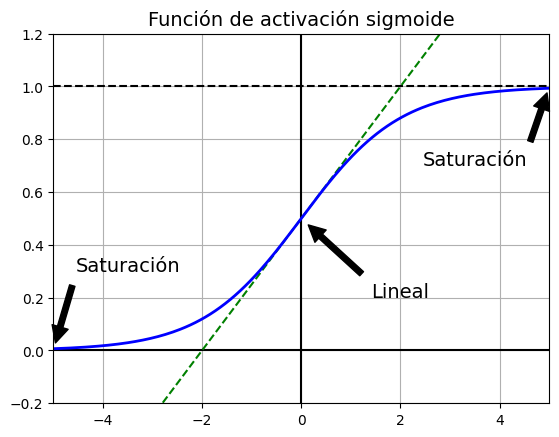

In [63]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturación', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturación', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Lineal', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Función de activación sigmoide", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

### Inicialización de los pesos

Estos problemas fueron los que impidieron a la comunidad utilizar las redes profundas antes, pero una inicialización inteligente de los pesos (que depende de las funciones de activación utilizadas) puede salvar el día: La idea es mantener la varianza de la salida de cada neurona lo más parecida posible a su entrada y con promedio cero:

Si definimos $\text{fan}_{\text{avg}}=\frac{1}{2}(\text{fan}_{\text{in}}+\text{fan}_{\text{out}})$, siendo  $\text{fan}_{\text{in}}$ y $\text{fan}_{\text{out}}$  el número de conexiones de entrada y salida de cada capa, las tres prescripciones de inicialización más relevantes son

*   *Xavier/ Glorot*: $\sigma^{2}=1/\text{fan}_{\text{avg}}$, útil cuando las funciones de actuación son la identidad, `tanh`, `sigmoide` y `softmax`.
*   *He*: $\sigma^{2}=2/\text{fan}_{\text{in}}$ útil para `relu` y sus variantes.
*   *LeCun*: $\sigma^{2}=1/\text{fan}_{\text{in}}$,  útil para `selu`.

Donde la inicialización se realiza con una función normal de varianza $\sigma^2$, o alternativamente una distribución uniforme en $[-r,r]$ con $r=\sqrt{3\sigma^2}$.

El valor por defecto en Keras es la inicialización de Glorot, pero se puede cambiar usando el parámetro `kernel_initializer`.

In [64]:
#ejemplo 1: inicialización de He
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

#ejemplo 2: inicialización personalizada
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Optimizadores

El optimizador es el algoritmo que le dice cómo cambiar los pesos del modelo, para disminuir la pérdida. Es una parte crucial del algoritmo. Ya hemos visto un algoritmo que es la base de todos los demás, el Stochastic Gradient Descent, pero hay muchos otros:

In [65]:
[name for name in dir(keras.optimizers) if (not name.startswith("_") and name[0].isupper())]

['Adadelta',
 'Adafactor',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'Ftrl',
 'Lion',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD']

Por defecto, la implementación de SGD en keras soporta algunas variantes básicas, como la Optimización del Momentum:

$\vec{m}\rightarrow \beta \vec{m} -\eta \nabla_{\vec{\theta}} J(\vec{\theta}) $

$\vec{\theta} \rightarrow \vec{\theta} + \vec{m}$

In [66]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

y su variante, el Gradiente de Nesterov acelerado:


$\vec{m}\rightarrow \beta \vec{m} -\eta \nabla_{\vec{\theta}} J(\vec{\theta}+\beta\vec{m}) $

$\vec{\theta} \rightarrow \vec{\theta} + \vec{m}$

In [82]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

También hay otras modificaciones, cuya intención es escalar la tasa de aprendizaje para aumentarla en la dirección en la que el cambio es pequeño, con el fin de acelerar la convergencia.

El primer ejemplo de un algoritmo de este tipo es el método `AdaGrad`.

In [83]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

Pero una variante que suele funcionar mejor es el `RMSProp`, que introduce un decaimiento exponencial en el boosting, controlado por un parámetro $\rho$ (normalmente ~0,9), y de esta manera evita el problema de AdaGrad de sobreadaptar la tasa de aprendizaje

In [84]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

Y una combinación popular de `RMSProp` con la optimización Momentum, que parece funcionar bastante bien, es el optimizador `Adam`. El parámetro `beta_1` controla la optimización Momentum, el `beta_2` controla el RMSProp, y `epsilon` es un número pequeño para evitar la división por cero.

In [85]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

También existen algunas variantes de Adam, Adamax y Nadam, pero no son tan utilizadas (que lo sepamos).

In [86]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Tasa de aprendizaje / _Learning Rate_

El hiperparámetro más importante que tenemos que ajustar en el proceso de ajuste de las redes neuronales, para acelerar la convergencia, es la tasa de aprendizaje. Hemos visto que algunos optimizadores, como Adam, son menos sensibles al valor inicial de la tasa de aprendizaje, pero aún así es una buena idea hacer un uso más eficiente de ella.

Una idea es probar diferentes tasas de aprendizaje, y ver la velocidad a la que disminuye la pérdida (un proceso que se conoce como aprendizaje en un ciclo). Pero incluso si hacemos esto, una estrategia común para evitar las mesetas de aprendizaje, es disminuir lentamente la tasa de aprendizaje a medida que avanza el entrenamiento. Esto se conoce como **Programación de la tasa de aprendizaje** (_Learning Rate Scheduling_) y puede implementarse a través de un _callback_.

Para definir una programación, debemos especificar cómo escalar la tasa de aprendizaje en función de la época de entrenamiento. Una forma de hacerlo es a través de una lei de potencia:
$$\eta = \frac{\eta_{0}}{(1+\text{epoch}/s)^{c}}$$

Esto se implementa de forma automática en el optimizador SGD, seteando $c=1$ y $s = 1/$decay:

In [67]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-4)

Otra opción común es introducir una programación exponencial a través de una llamada de retorno, que reduce drásticamente la tasa de aprendizaje en cada paso

$\eta = \eta_{0}\cdot0.1^{\text{epoch}/s}$

Para implementar esto, podemos utilizar el `keras.callbacks.LearningRateScheduler`, al que podemos pasar una función arbitraria de la época, y utilizarla como _callback_.

In [68]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

#esto es lo mismo que deifnir
#def exponential_decay_fn(epoch):
#    return 0.01 * 0.1**(epoch / 20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Ejemplo de regresión: volviendo a las viviendas en California

Para mostrarles el _pipeline_, desarrollaremos ahora un ejemplo de regresión. Utilizaremos el mismo conjunto de datos de California Housing que utilizamos en nuestras primeras clases.

Aquí importamos el modelo, dividimos el conjunto de datos en conjuntos de entrenamiento, validación y prueba, y lo normalizamos.


In [70]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Definiremos un modelo simple, con una sola capa oculta, y sin función de activación en la última capa

In [71]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [72]:
X_train.shape[1:]

(8,)

In [73]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30)                270       
                                                                 
 dense_13 (Dense)            (None, 1)                 31        
                                                                 
Total params: 301 (1.18 KB)
Trainable params: 301 (1.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Fiteamos el modelo

In [74]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
363/363 [==============================] - 2s 4ms/step - loss: 2.4321 - val_loss: 1.4502
Epoch 2/50
363/363 [==============================] - 1s 4ms/step - loss: 0.9253 - val_loss: 0.7723
Epoch 3/50
363/363 [==============================] - 1s 3ms/step - loss: 0.7176 - val_loss: 0.7156
Epoch 4/50
363/363 [==============================] - 1s 4ms/step - loss: 0.6445 - val_loss: 0.6062
Epoch 5/50
363/363 [==============================] - 1s 4ms/step - loss: 0.5985 - val_loss: 0.5554
Epoch 6/50
363/363 [==============================] - 2s 5ms/step - loss: 0.5621 - val_loss: 0.5344
Epoch 7/50
363/363 [==============================] - 1s 4ms/step - loss: 0.5353 - val_loss: 0.5344
Epoch 8/50
363/363 [==============================] - 1s 4ms/step - loss: 0.5138 - val_loss: 0.4774
Epoch 9/50
363/363 [==============================] - 1s 4ms/step - loss: 0.4954 - val_loss: 0.4622
Epoch 10/50
363/363 [==============================] - 1s 4ms/step - loss: 0.4810 - val_loss: 0.4573

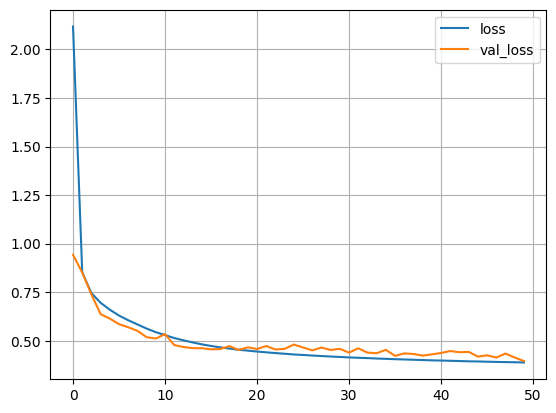

In [96]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

Y lo evaluamos en el conjunto de testeo

In [75]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3793


Hacemos predicciones para nuevos datos

In [76]:
X_new = X_test[:10]
y_pred = model.predict(X_new)
print(y_pred)

1/1 [==============================] - 0s 64ms/step
[[0.5599805]
 [1.7273647]
 [3.496029 ]
 [2.5614376]
 [2.8108253]
 [1.8002864]
 [2.6547534]
 [1.6837987]
 [2.862596 ]
 [4.0685616]]
